<a href="https://colab.research.google.com/github/cseifert512/Centralized-repository-shipping_calculations/blob/main/Trainv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision timm --quiet
!pip install transformers --quiet

from google.colab import drive
drive.mount('/content/drive')

#Replace w/your zip location
!unzip -q "/content/drive/MyDrive/Model_Training/model-training.zip" -d "/content/dataset"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
import os, torch, timm, numpy as np, matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [ ]:
# Dataset home:
DATA_DIR   = "/content/dataset/model-training"
TRAIN_DIR  = os.path.join(DATA_DIR, "train")
VAL_DIR    = os.path.join(DATA_DIR, "validate")
TEST_DIR   = os.path.join(DATA_DIR, "test")

# Training hyperparameters:
IMG_SIZE    = 224
BATCH_SIZE  = 32
NUM_WORKERS = 4
LR          = 1e-3
WEIGHT_DECAY= 1e-4
EPOCHS      = 20
SEED        = 42
torch.manual_seed(SEED)
np.random.seed(SEED)


Classes: ['10_Arc_Groin_Half', '11_One_Sheet_Hyperboloid_Uncapped', '1_Gothic_Groin', '2_Gothic_Barrel', '3_Gothic_BarrelV_Quarter(baddatafyi', '4_Gothic_Arch_Revolved180', '5_Dome_Hollow', '6_Dome_Half_Hollow', '7_Barrel_norm', '8_Barrel_Groin', '9_Arc_Groin_Quarter']
Counts: 1254 418 418


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


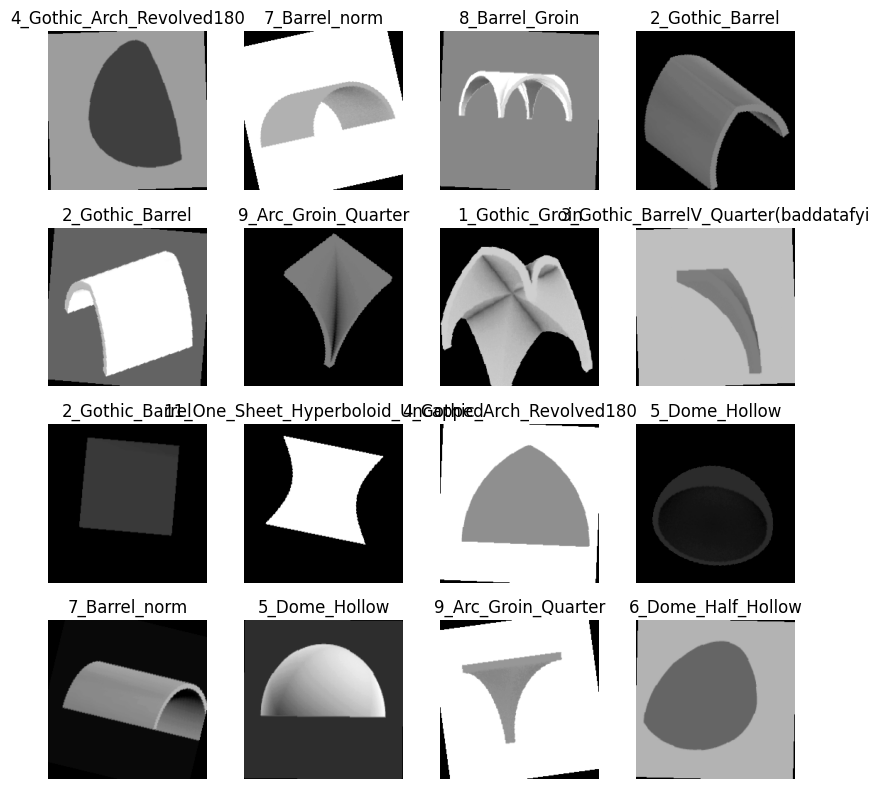

In [ ]:
# Transforms
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomRotation(15, fill=1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
eval_tf = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# Datasets & Loaders
train_ds = ImageFolder(TRAIN_DIR, transform=train_tf)
val_ds   = ImageFolder(VAL_DIR,   transform=eval_tf)
test_ds  = ImageFolder(TEST_DIR,  transform=eval_tf)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("Counts:", len(train_ds), len(val_ds), len(test_ds))

# Quick visual check
imgs, lbls = next(iter(train_loader))
fig, axs = plt.subplots(4,4,figsize=(8,8))
for img, lbl, ax in zip(imgs, lbls, axs.flatten()):
    ax.imshow(img.permute(1,2,0).cpu())
    ax.set_title(train_ds.classes[lbl])
    ax.axis('off')
plt.tight_layout()


In [ ]:
#Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_small_patch16_224', pretrained=True)
in_feats   = model.head.in_features
model.head = torch.nn.Linear(in_feats, len(train_ds.classes))
model = model.to(device).eval()

# — Unfreeze last block and new head —
for param in model.parameters():
    param.requires_grad = False
for param in model.head.parameters():
    param.requires_grad = True
    # unfreeze last ViT block
for param in model.blocks[-1].parameters():
    param.requires_grad = True

# — Replace head with 2-layer MLP for more capacity —
in_feats = model.head.in_features
model.head = torch.nn.Sequential(
    torch.nn.Linear(in_feats, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, num_classes)
).to(device)

# Dummy forward to check shapes
batch, _ = next(iter(train_loader))
with torch.no_grad():
    logits = model(batch.to(device))
print("Logits shape:", logits.shape)  # should be [BATCH_SIZE, num_classes]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Logits shape: torch.Size([32, 11])


In [ ]:
#Loss, Optimizer, Scheduler & Training Loop

EPOCHS = 15

from transformers import get_cosine_schedule_with_warmup #for scheduler


# 1) Define loss and optimizer (hyperparameters LR, WEIGHT_DECAY, EPOCHS are set in Cell 3)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)


total_steps  = len(train_loader) * EPOCHS
warmup_steps = int(0.1 * total_steps)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

# 2) Training & validation
best_val_acc = 0.0
history      = []  # list of (epoch, train_loss, train_acc, val_loss, val_acc)

for epoch in range(1, EPOCHS + 1):
    # — Training phase —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    # — Validation phase —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    # — Checkpoint the best model —
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_head.pt")

    scheduler.step()

    history.append((epoch, train_loss, train_acc, val_loss, val_acc))
    print(f"Epoch {epoch}/{EPOCHS} ▶ "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.2%} | "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.2%}")


Epoch 1/15 ▶ Train: loss=2.6046, acc=10.29% | Val:   loss=2.5274, acc=11.24%
Epoch 2/15 ▶ Train: loss=2.4015, acc=15.79% | Val:   loss=2.2848, acc=18.90%
Epoch 3/15 ▶ Train: loss=2.0655, acc=32.06% | Val:   loss=1.9374, acc=27.75%
Epoch 4/15 ▶ Train: loss=1.6757, acc=44.98% | Val:   loss=1.5595, acc=43.30%
Epoch 5/15 ▶ Train: loss=1.3034, acc=55.26% | Val:   loss=1.2422, acc=57.89%
Epoch 6/15 ▶ Train: loss=1.0232, acc=64.43% | Val:   loss=0.9875, acc=68.66%
Epoch 7/15 ▶ Train: loss=0.7912, acc=72.73% | Val:   loss=0.8175, acc=76.32%
Epoch 8/15 ▶ Train: loss=0.6562, acc=76.79% | Val:   loss=0.7020, acc=77.99%
Epoch 9/15 ▶ Train: loss=0.5960, acc=78.39% | Val:   loss=0.6216, acc=77.99%
Epoch 10/15 ▶ Train: loss=0.5393, acc=80.06% | Val:   loss=0.5453, acc=84.69%
Epoch 11/15 ▶ Train: loss=0.4428, acc=84.05% | Val:   loss=0.5019, acc=85.41%
Epoch 12/15 ▶ Train: loss=0.4336, acc=82.14% | Val:   loss=0.4690, acc=87.08%
Epoch 13/15 ▶ Train: loss=0.4326, acc=83.89% | Val:   loss=0.4297, acc=85

In [ ]:
#Confirm data diversity in test_loader
print("Test batch labels:", next(iter(test_loader))[1].tolist())

#Sample some predictions
model.eval()
with torch.no_grad():
    imgs, lbls = next(iter(test_loader))
    preds = model(imgs.to(device)).argmax(dim=1).cpu().tolist()
print("Sample preds:", preds[:10])
print("Sample truths:", lbls[:10].tolist())


Test batch labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample preds: [8, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Sample truths: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.7691, Test Accuracy: 75.60%


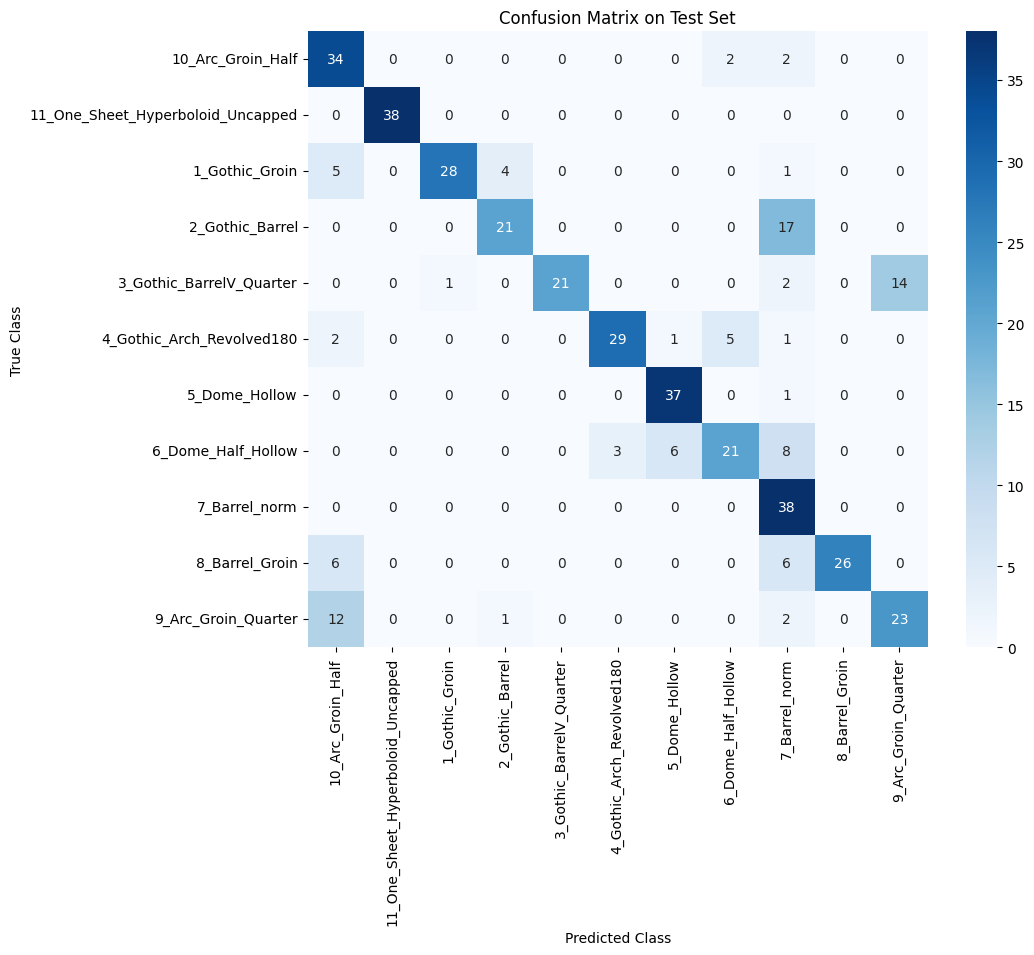

In [ ]:
#Test Evaluation& Confusion Matrix

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1) Load the best model checkpoint
model.load_state_dict(torch.load("best_head.pt"))
model.eval()

#Creating test_loader before using it
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# 2) Run on the test set & collect predictions
total_loss = 0.0
total_correct = 0
total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3) Compute and print test metrics
test_loss = total_loss / total_samples
test_acc  = total_correct / total_samples
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2%}")

# 4) Plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=test_ds.classes,
            yticklabels=test_ds.classes,
            cmap="Blues")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix on Test Set")
plt.show()


In [ ]:
!pip install captum --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
#Saliency Maps with Integrated Gradients ──


import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from captum.attr import IntegratedGradients
import numpy as np

# (Re-use your pad_edge and norm transforms from Cell 3)
# pad_edge: ResizeWithPaddingEdge(224)
# norm: ToTensor + Normalize

# 1) Helper to un-normalize for display
def unnorm(tensor):
    return (tensor * 0.5 + 0.5).clamp(0,1)

# 2) Initialize Captum
ig = IntegratedGradients(model)

# 3) Directory for your real fragments and for saving saliency
frag_dir    = "/content/choisy_test"           # your folder of real images
sal_dir     = "fragment_saliency"
os.makedirs(sal_dir, exist_ok=True)

# 4) Loop through fragments
for fn in os.listdir(frag_dir):
    if not fn.lower().endswith(('.png','.jpg','.jpeg')): continue

    # a) Load & preprocess
    img = Image.open(os.path.join(frag_dir,fn)).convert('RGB')
    padded = pad_edge(img)
    inp = norm(padded).unsqueeze(0).to(device)

    # b) Predict & choose target class
    model.eval()
    with torch.no_grad():
        logits = model(inp)
    pred = logits.argmax(dim=1).item()

    # c) Compute Integrated Gradients
    # baseline = zero tensor (black image); you could also use pad_edge(img)*0
    baseline = torch.zeros_like(inp)
    attr, delta = ig.attribute(
        inp,
        baselines=baseline,
        target=pred,
        return_convergence_delta=True,
        n_steps=50
    )
    sal = attr.abs().sum(dim=1)[0].cpu().numpy()  # [H,W]
    sal = (sal - sal.min()) / (sal.max() - sal.min() + 1e-8)

    # d) Plot & save
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    ax[0].imshow(unnorm(inp[0]).permute(1,2,0).cpu())
    ax[0].set_title(f"Pred: {train_ds.classes[pred]}")
    ax[0].axis('off')

    ax[1].imshow(unnorm(inp[0]).permute(1,2,0).cpu())
    ax[1].imshow(sal, cmap='hot', alpha=0.6)
    ax[1].set_title("Integrated Gradients")
    ax[1].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(sal_dir, fn.replace('.', '_sal.png')))
    plt.close(fig)


NameError: name 'pad_edge' is not defined